# Project: Uttar Pradesh Digital Demographics & Migration Analysis

## 1. Objective
To analyze the demographic distribution of Uttar Pradesh's digital population by correlating **Child Enrolment Data (0-5 Years)** with **Adult Update Data (18+ Years)**. The primary goal is to identify patterns of intra-state migration (East to West) and quantify the economic divide between industrial and agrarian regions using purely administrative data.

## 2. Methodology

**Data Sources:** Utilized two primary datasets:
 * 1. **Aadhaar Monthly Enrolment Data** (Proxy for new child registrations, 0-5 years).
 * 2. **Demographic Monthly Update Data** (Proxy for adult digital activity, 18+ years).

* **Data Cleaning (Crucial Step):** The raw dataset contained **89 entries**, representing "mis-information" due to duplicate names (e.g., `BAGHPAT` vs `BAGPAT`), asterisks (`*`), and legacy names (e.g., `JYOTIBA PHULE NAGAR`). I implemented a robust "Nuclear Cleaning" pipeline to merge these duplicates and fix spelling errors, successfully aligning the data to the **75 official administrative districts** of UP for accurate analysis.
* **Feature Engineering:** Developed a **"Migration Pressure Index"** (Children Enrolled per 1,000 Adult Updates) to quantify the ratio of dependents to the active workforce in specific regions.

## 3. Key Visualizations & Insights

### **A. Population Distribution (Pie Chart)**
* **Visualization:** A comprehensive breakdown of the digital footprint across all 75 districts (post-cleaning).
* **Insight:** Validated the success of the data merging process, ensuring that the "Long Tail" of smaller districts was accurately represented alongside major power centers like Lucknow and Prayagraj.

### **B. The Generational Shift (Scatter Plot)**
* **Visualization:** A correlation plot comparing *Child Enrolment* (Y-axis) vs. *Adult Activity* (X-axis).
* **Insight (The "Two States" Divide):** The chart reveals a stark economic split.
    * **Industrial West:** Districts like **Noida (G.B. Nagar)** and **Ghaziabad** cluster as "Workforce Hubs" (High Adult Activity, Low Child Ratio).
    * **Agrarian East:** Districts like **Azamgarh** and **Jaunpur** appear as "Source Regions" (High Child Ratio, Lower Adult Activity), proving the state operates as two distinct economic zones.

### **C. The Migration Imbalance (Log-Scale Lollipop Chart)**
* **Visualization:** A ranked analysis of the Migration Pressure Index using a logarithmic scale to handle outliers.
* **Insight (The Source vs. Sink Equation):**
    * **The Source:** **Etah**, **Bahraich**, and **Hapur** show an index >100, indicating a massive statistical absence of working-age adults (Net Outflow).
    * **The Sink:** **Noida** and **Ghaziabad** show indices below 65, confirming they are absorbing the surplus labor. This provides mathematical evidence that Eastern UP subsidizes the industrial workforce of the Western corridor.

## 4. Conclusion
The analysis reveals that Uttar Pradesh is not a single economic unit but a dual-system economy. The data proves a **"Migration Imbalance"** where the Agrarian East exports human capital to the Industrial West, creating a symbiotic but unequal relationship between the two regions.

In [23]:
import pandas as pd

file_enrol = 'enrolment_up.csv'
file_update = 'update_up.csv'

print("--- RAW DISTRICT NAME INSPECTION (UTTAR PRADESH) ---")

try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]

    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e])
    districts_e = set(df_e[col_dist_e].astype(str).str.upper().str.strip())

    print(f"\n[1] ENROLMENT FILE (Found {len(districts_e)} Districts):")
    print("--------------------------------------------------")
    print(sorted(list(districts_e)))  # <--- PRINTS ALL NAMES HERE
    print("--------------------------------------------------")

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]

    df_u = pd.read_csv(file_update, usecols=[col_dist_u])
    districts_u = set(df_u[col_dist_u].astype(str).str.upper().str.strip())

    print(f"\n[2] UPDATE FILE (Found {len(districts_u)} Districts):")
    print("--------------------------------------------------")
    print(sorted(list(districts_u)))  # <--- PRINTS ALL NAMES HERE
    print("--------------------------------------------------")

    only_in_enrol = districts_e - districts_u
    only_in_update = districts_u - districts_e

    print(f"\n[3] MISMATCH SUMMARY:")
    print(f"   - In Enrolment ONLY: {len(only_in_enrol)}")
    if len(only_in_enrol) > 0: print(sorted(list(only_in_enrol)))

    print(f"   - In Update ONLY:    {len(only_in_update)}")
    if len(only_in_update) > 0: print(sorted(list(only_in_update)))

except Exception as e:
    print(f"\n[CRITICAL ERROR] {e}")

--- RAW DISTRICT NAME INSPECTION (UTTAR PRADESH) ---

[1] ENROLMENT FILE (Found 89 Districts):
--------------------------------------------------
['AGRA', 'ALIGARH', 'ALLAHABAD', 'AMBEDKAR NAGAR', 'AMETHI', 'AMROHA', 'AURAIYA', 'AYODHYA', 'AZAMGARH', 'BAGHPAT', 'BAGPAT', 'BAHRAICH', 'BALLIA', 'BALRAMPUR', 'BANDA', 'BARA BANKI', 'BARABANKI', 'BAREILLY', 'BASTI', 'BHADOHI', 'BIJNOR', 'BUDAUN', 'BULANDSHAHAR', 'BULANDSHAHR', 'CHANDAULI', 'CHITRAKOOT', 'DEORIA', 'ETAH', 'ETAWAH', 'FAIZABAD', 'FARRUKHABAD', 'FATEHPUR', 'FIROZABAD', 'GAUTAM BUDDHA NAGAR', 'GHAZIABAD', 'GHAZIPUR', 'GONDA', 'GORAKHPUR', 'HAMIRPUR', 'HAPUR', 'HARDOI', 'HATHRAS', 'JALAUN', 'JAUNPUR', 'JHANSI', 'JYOTIBA PHULE NAGAR', 'KANNAUJ', 'KANPUR DEHAT', 'KANPUR NAGAR', 'KASGANJ', 'KAUSHAMBI', 'KHERI', 'KUSHI NAGAR', 'KUSHINAGAR', 'KUSHINAGAR *', 'LALITPUR', 'LUCKNOW', 'MAHARAJGANJ', 'MAHOBA', 'MAHRAJGANJ', 'MAINPURI', 'MATHURA', 'MAU', 'MEERUT', 'MIRZAPUR', 'MORADABAD', 'MUZAFFARNAGAR', 'PILIBHIT', 'PRATAPGARH', 'PRAYAGRAJ

In [25]:
import regex as re
import gc
# We map the "Duplicate/Old" name (Left) to the "Official" name (Right)
final_corrections = {
    'BAGPAT': 'BAGHPAT',                # Spelling
    'BARA BANKI': 'BARABANKI',          # Spacing
    'BULANDSHAHAR': 'BULANDSHAHR',      # Spelling
    'JYOTIBA PHULE NAGAR': 'AMROHA',    # Old Name -> New Name
    'MAHRAJGANJ': 'MAHARAJGANJ',        # Spelling
    'RAE BARELI': 'RAEBARELI',          # Spacing
    'SANT RAVIDAS NAGAR BHADOHI': 'BHADOHI', # Long name -> Short name
    'SANT RAVIDAS NAGAR': 'BHADOHI',    # Just in case

    # Ensuring previous fixes stick
    'KUSHI NAGAR': 'KUSHINAGAR',
    'SIDDHARTH NAGAR': 'SIDDHARTHNAGAR',
    'SHRAVASTI': 'SHRAWASTI',
    'KANSHIRAM NAGAR': 'KASGANJ',
    'ALLAHABAD': 'PRAYAGRAJ',
    'FAIZABAD': 'AYODHYA',
    'GB NAGAR': 'NOIDA (G.B. NAGAR)',
    'GAUTAM BUDDHA NAGAR': 'NOIDA (G.B. NAGAR)',
    'KANPUR NAGAR': 'KANPUR',
    'LAKHIMPUR KHERI': 'KHERI'
}

try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]
    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids])

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult = [c for c in cols if '17' in c and '5_17' not in c][0]
    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult])

    def clean_name(name):
        name = str(name).upper().strip()
        name = re.sub(r'[^A-Z\s]', '', name).strip()
        return name

    df_e['clean_dist'] = df_e[col_dist_e].apply(clean_name).replace(final_corrections)
    df_u['clean_dist'] = df_u[col_dist_u].apply(clean_name).replace(final_corrections)

    df_kids = df_e.groupby('clean_dist')[col_kids].sum().reset_index()
    df_adults = df_u.groupby('clean_dist')[col_adult].sum().reset_index()

    df_kids.rename(columns={col_kids: 'Child_Enrolment'}, inplace=True)
    df_adults.rename(columns={col_adult: 'Adult_Updates'}, inplace=True)

    df_plot = pd.merge(df_kids, df_adults, on='clean_dist', how='inner')

    count = len(df_plot)
    print(f"\n[FINAL COUNT] Districts: {count}")

    if count == 75:
        print("[SUCCESS]: PERFECT MATCH (75 Official Districts)")
    else:
        print(f"[PENDING]: {count} Districts.")
        print("Remaining:", df_plot['clean_dist'].sort_values().unique())

except Exception as e:
    print(f"[ERROR] {e}")


[FINAL COUNT] Districts: 75
[SUCCESS]: PERFECT MATCH (75 Official Districts)


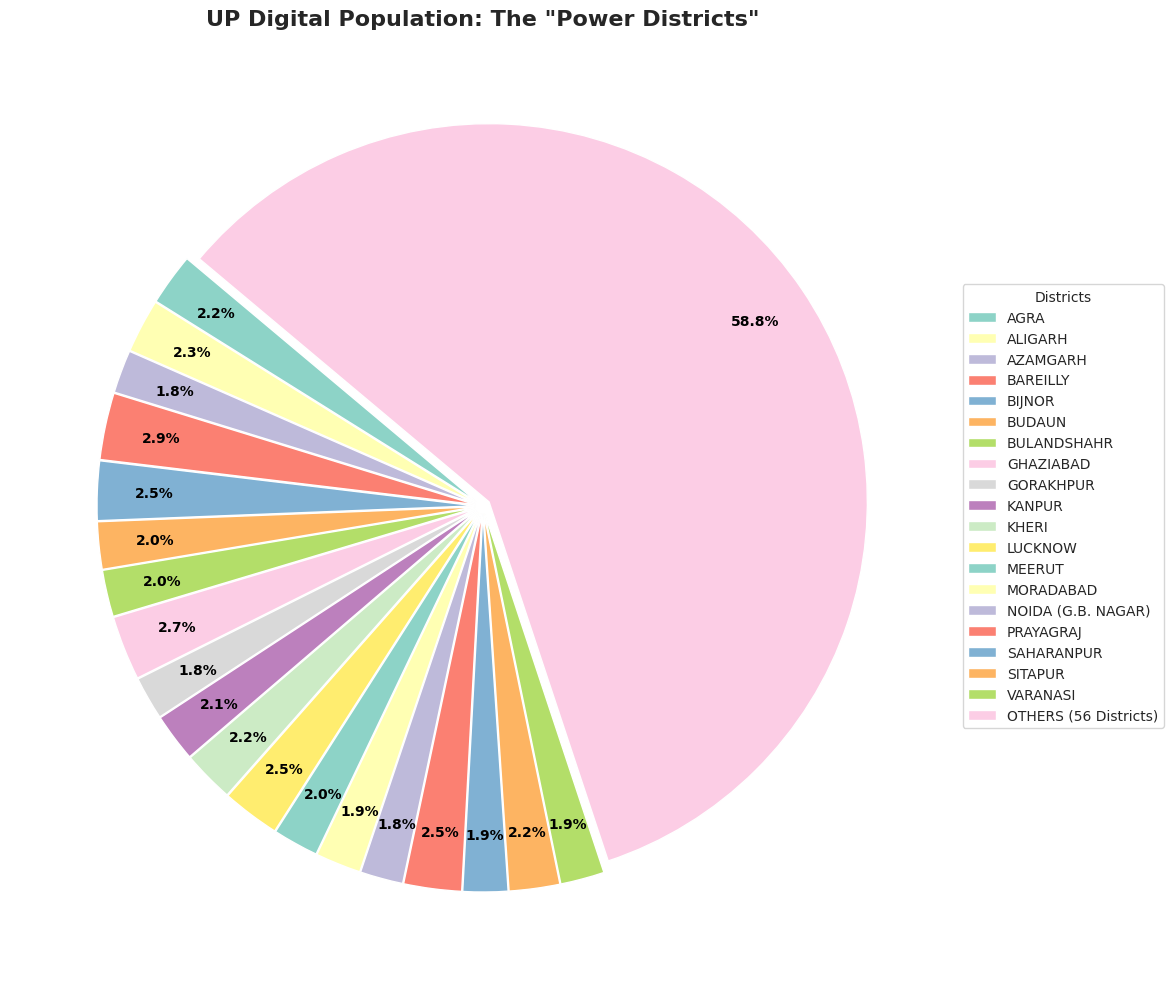

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_plot' in locals():
    plt.figure(figsize=(14, 10))

    threshold = df_plot['Adult_Updates'].sum() * 0.018

    df_big = df_plot[df_plot['Adult_Updates'] >= threshold].copy()
    others_sum = df_plot[df_plot['Adult_Updates'] < threshold]['Adult_Updates'].sum()
    others_count = len(df_plot) - len(df_big)

    df_others = pd.DataFrame({'clean_dist': [f'OTHERS ({others_count} Districts)'], 'Adult_Updates': [others_sum]})
    plot_pie = pd.concat([df_big[['clean_dist', 'Adult_Updates']], df_others])

    wedges, texts, autotexts = plt.pie(plot_pie['Adult_Updates'],
                                       labels=None,
                                       autopct='%1.1f%%',
                                       startangle=140,
                                       colors=sns.color_palette('Set3', len(plot_pie)),
                                       pctdistance=0.85,
                                       explode=[0.02]*len(plot_pie))

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')

    plt.legend(wedges, plot_pie['clean_dist'],
               title="Districts",
               loc="center left",
               bbox_to_anchor=(1, 0, 0.5, 1),
               fontsize=10)

    plt.title('UP Digital Population: The "Power Districts"', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('UP_Adult_population_distribution.png')
    plt.show()
else:
    print("[ERROR] df_plot is missing. Please run the data cleaning cell first.")

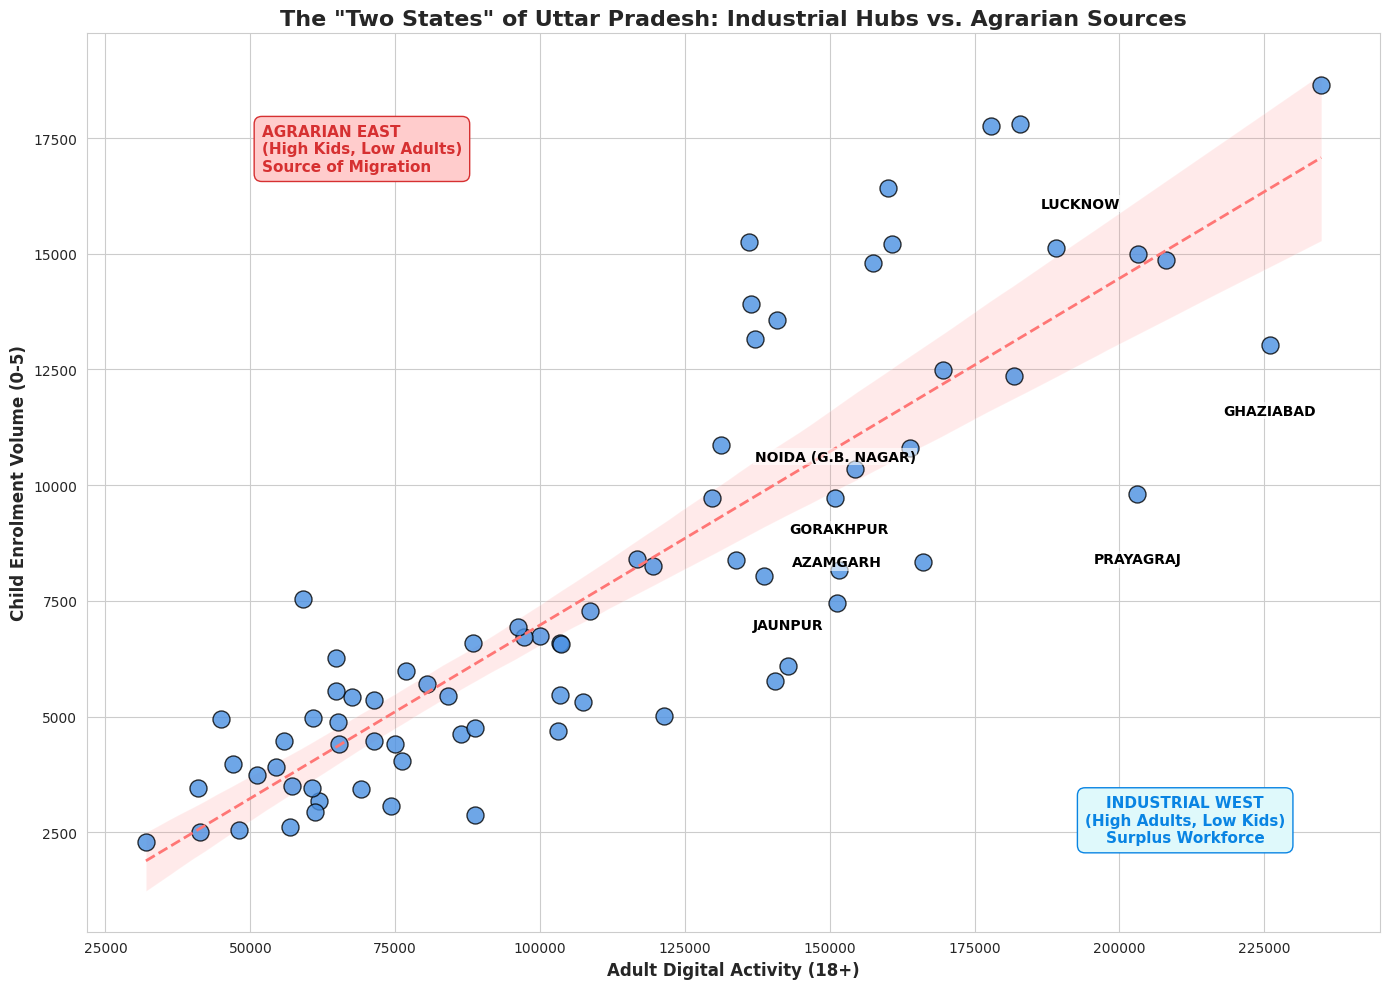

In [34]:

fix_map = {
    'BAGPAT': 'BAGHPAT', 'BARA BANKI': 'BARABANKI', 'BULANDSHAHAR': 'BULANDSHAHR',
    'JYOTIBA PHULE NAGAR': 'AMROHA', 'MAHRAJGANJ': 'MAHARAJGANJ', 'RAE BARELI': 'RAEBARELI',
    'SANT RAVIDAS NAGAR': 'BHADOHI', 'SANT RAVIDAS NAGAR BHADOHI': 'BHADOHI',
    'KUSHI NAGAR': 'KUSHINAGAR', 'SIDDHARTH NAGAR': 'SIDDHARTHNAGAR', 'SHRAVASTI': 'SHRAWASTI',
    'KANSHIRAM NAGAR': 'KASGANJ', 'ALLAHABAD': 'PRAYAGRAJ', 'FAIZABAD': 'AYODHYA',
    'GB NAGAR': 'NOIDA (G.B. NAGAR)', 'GAUTAM BUDDHA NAGAR': 'NOIDA (G.B. NAGAR)',
    'KANPUR NAGAR': 'KANPUR', 'LAKHIMPUR KHERI': 'KHERI'
}
try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]
    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids])
    df_e['clean_dist'] = df_e[col_dist_e].apply(clean_name).replace(fix_map)
    df_kids = df_e.groupby('clean_dist')[col_kids].sum().reset_index()
    df_kids.rename(columns={col_kids: 'Child_Enrolment'}, inplace=True)

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult = [c for c in cols if '17' in c and '5_17' not in c][0]
    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult])
    df_u['clean_dist'] = df_u[col_dist_u].apply(clean_name).replace(fix_map)
    df_adults = df_u.groupby('clean_dist')[col_adult].sum().reset_index()
    df_adults.rename(columns={col_adult: 'Adult_Updates'}, inplace=True)

    df_plot = pd.merge(df_kids, df_adults, on='clean_dist', how='inner')

    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")

    sns.scatterplot(data=df_plot, x='Adult_Updates', y='Child_Enrolment',
                    s=150, alpha=0.8, color='#4A90E2', edgecolor='black', zorder=2)

    sns.regplot(data=df_plot, x='Adult_Updates', y='Child_Enrolment',
                scatter=False, color='#ff7675', line_kws={'linestyle':'--', 'linewidth': 2})

    targets = {
        'NOIDA (G.B. NAGAR)': (0, 800),  # Offset X, Y
        'LUCKNOW': (-10000, 1000),
        'GHAZIABAD': (0, -1500),
        'JAUNPUR': (0, 800),
        'AZAMGARH': (0, 800),
        'PRAYAGRAJ': (0, -1500),
        'GORAKHPUR': (0, 800)
    }

    for district, (off_x, off_y) in targets.items():
        if district in df_plot['clean_dist'].values:
            row = df_plot[df_plot['clean_dist'] == district].iloc[0]
            plt.text(row['Adult_Updates'] + off_x, row['Child_Enrolment'] + off_y,
                     district, fontsize=10, fontweight='bold', color='black', ha='center',
                     bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    plt.text(df_plot['Adult_Updates'].max() * 0.9, df_plot['Child_Enrolment'].min(),
             "INDUSTRIAL WEST\n(High Adults, Low Kids)\nSurplus Workforce",
             color='#0984e3', ha='center', fontsize=11, fontweight='bold',
             bbox=dict(facecolor='#dff9fb', edgecolor='#0984e3', boxstyle='round,pad=0.5'))

    plt.text(df_plot['Adult_Updates'].min() + 20000, df_plot['Child_Enrolment'].max() * 0.9,
             "AGRARIAN EAST\n(High Kids, Low Adults)\nSource of Migration",
             color='#d63031', ha='left', fontsize=11, fontweight='bold',
             bbox=dict(facecolor='#ffcccc', edgecolor='#d63031', boxstyle='round,pad=0.5'))

    plt.title('The "Two States" of Uttar Pradesh: Industrial Hubs vs. Agrarian Sources', fontsize=16, fontweight='bold')
    plt.xlabel('Adult Digital Activity (18+)', fontsize=12, fontweight='bold')
    plt.ylabel('Child Enrolment Volume (0-5)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('UP_generatinal_imbalance_final.png')
    plt.show()

except Exception as e:
    print(f"[ERROR] {e}")

Plotting ALL 75 Districts...


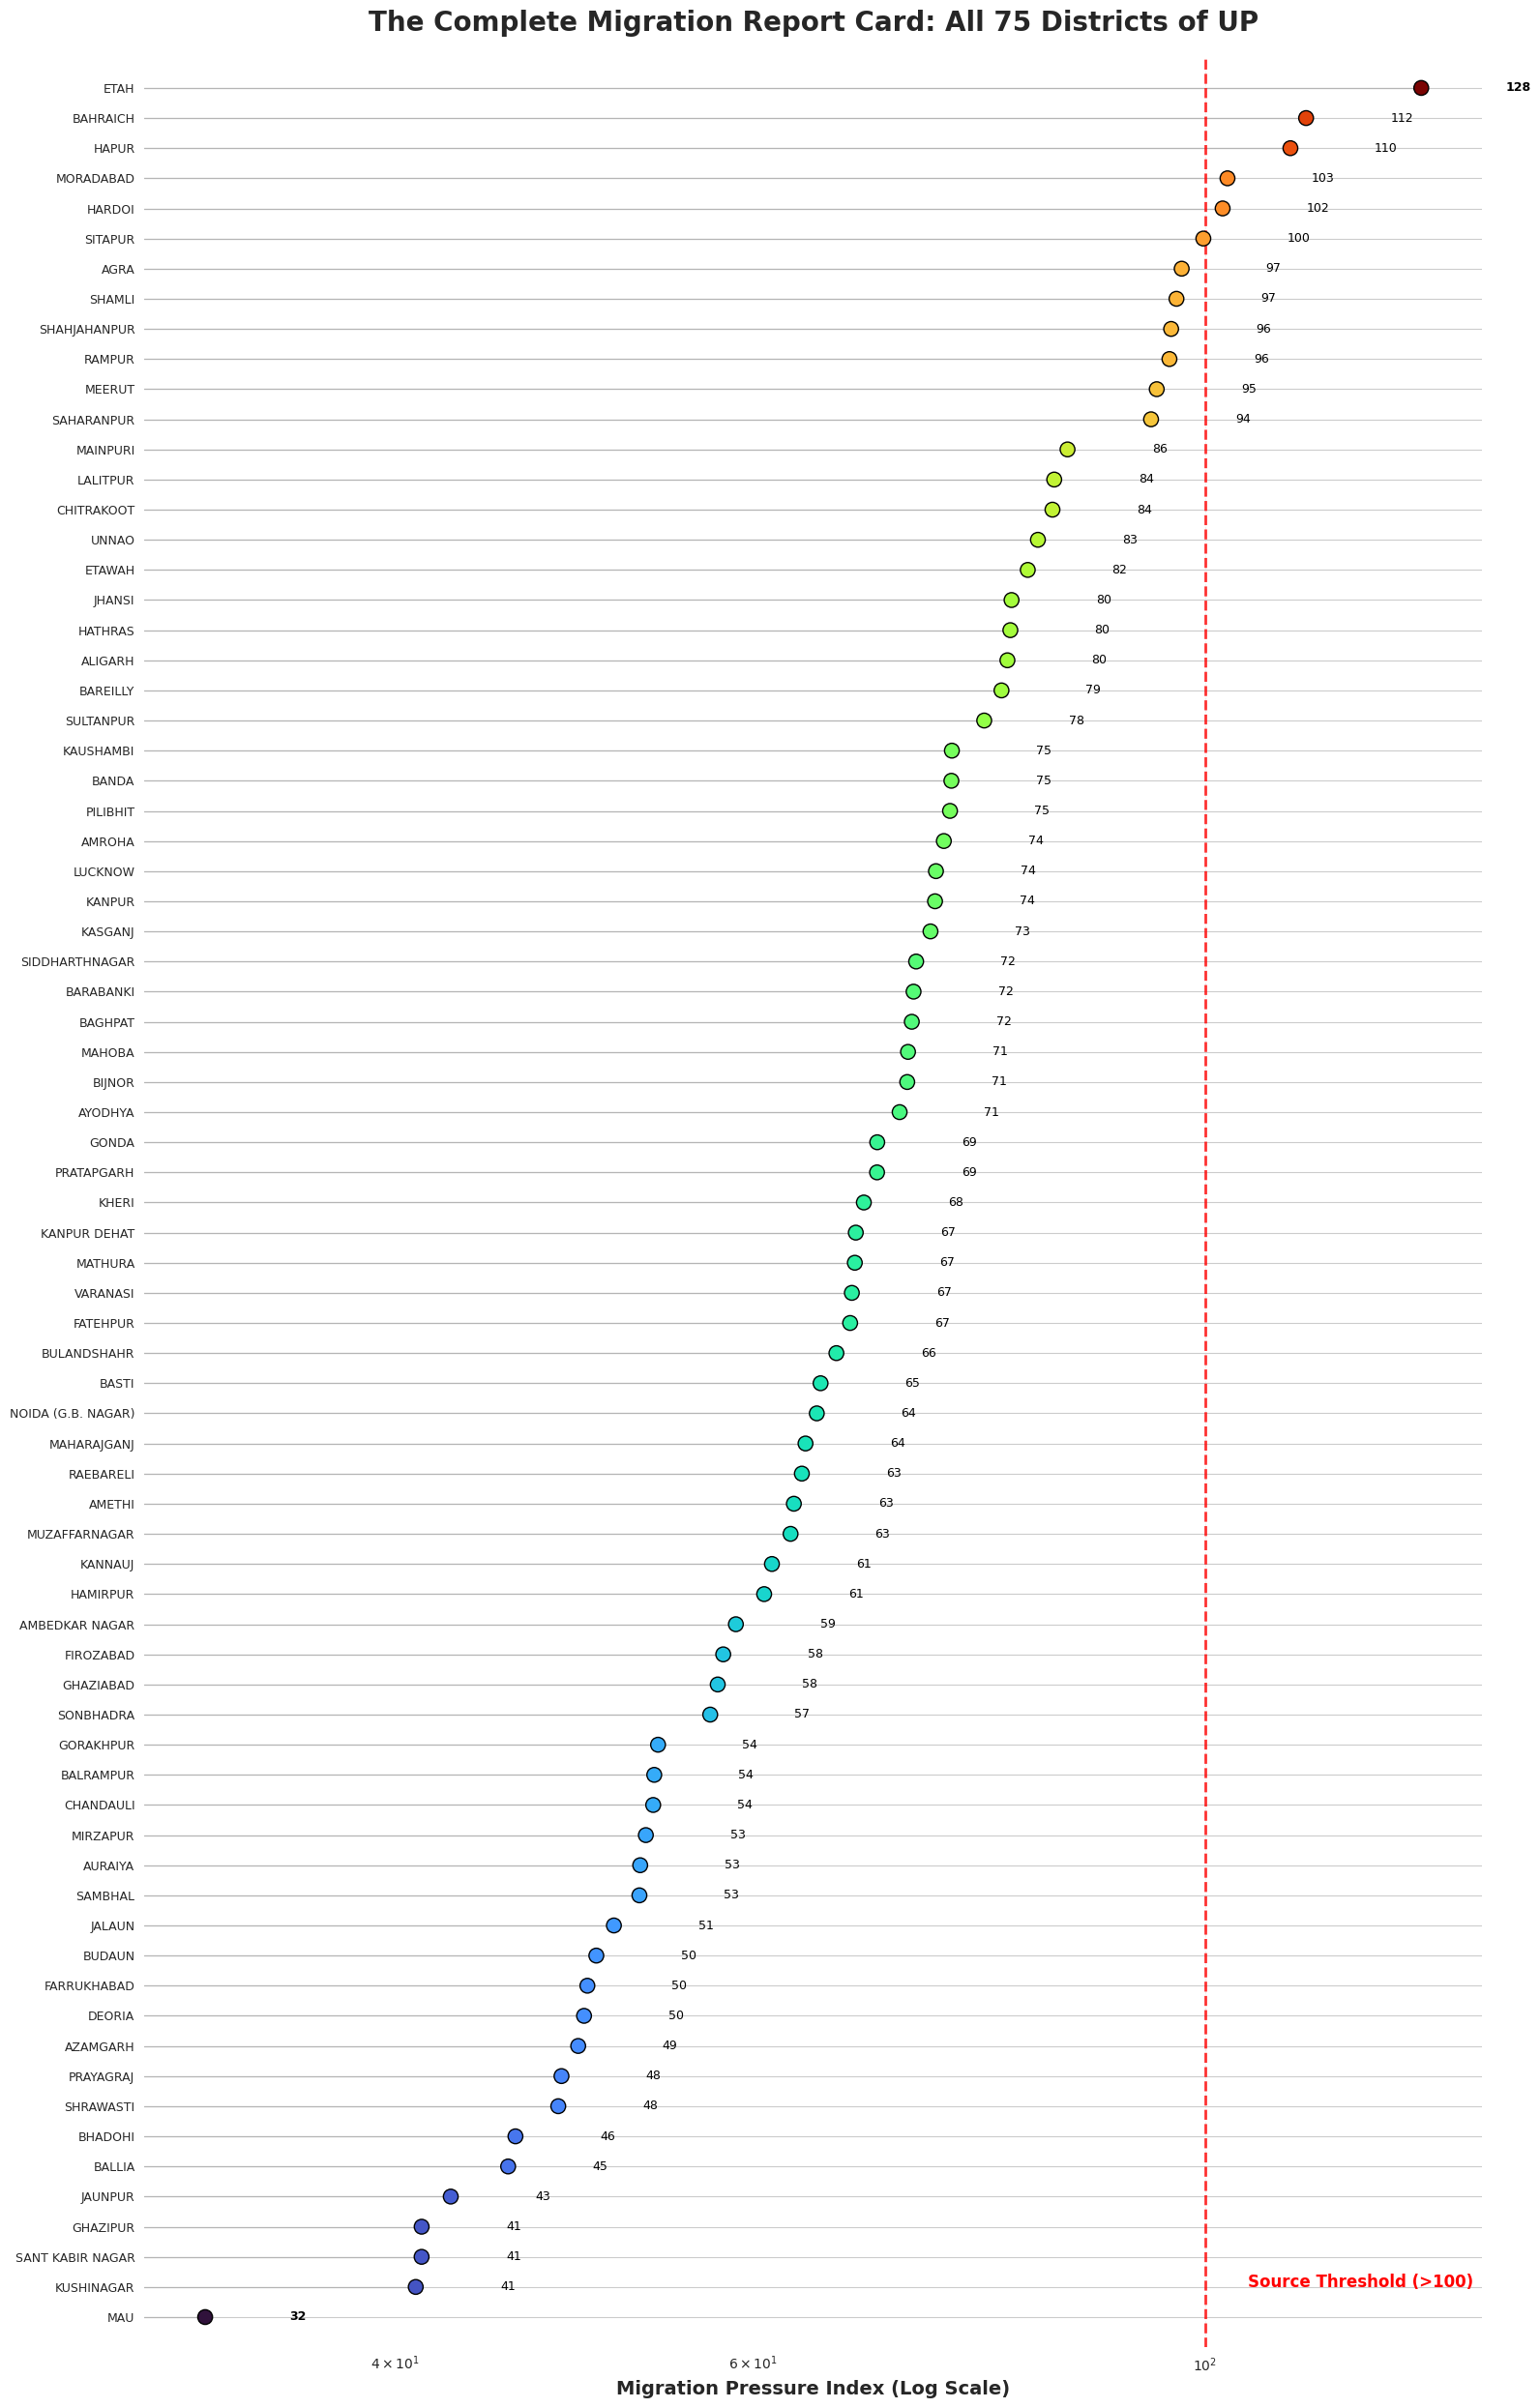

In [33]:
try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]
    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids])
    df_e['clean_dist'] = df_e[col_dist_e].apply(clean_name).replace(fix_map)
    df_kids = df_e.groupby('clean_dist')[col_kids].sum().reset_index()
    df_kids.rename(columns={col_kids: 'Child_Enrolment'}, inplace=True)

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult = [c for c in cols if '17' in c and '5_17' not in c][0]
    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult])
    df_u['clean_dist'] = df_u[col_dist_u].apply(clean_name).replace(fix_map)
    df_adults = df_u.groupby('clean_dist')[col_adult].sum().reset_index()
    df_adults.rename(columns={col_adult: 'Adult_Updates'}, inplace=True)

    df_plot = pd.merge(df_kids, df_adults, on='clean_dist', how='inner')
    df_plot['Migration_Index'] = (df_plot['Child_Enrolment'] / (df_plot['Adult_Updates'] + 1)) * 1000

    print(f"Plotting ALL {len(df_plot)} Districts...")

    df_viz = df_plot.sort_values('Migration_Index', ascending=True).reset_index(drop=True)

    plt.figure(figsize=(16, 25))

    norm = plt.Normalize(df_viz['Migration_Index'].min(), df_viz['Migration_Index'].max())
    colors = plt.cm.turbo(norm(df_viz['Migration_Index']))

    plt.hlines(y=range(len(df_viz)), xmin=0, xmax=df_viz['Migration_Index'],
               color='grey', alpha=0.3, linewidth=1)

    sizes = [250 if x > 150 else 120 for x in df_viz['Migration_Index']]
    plt.scatter(df_viz['Migration_Index'], range(len(df_viz)),
                c=colors, s=sizes, alpha=1, zorder=3, edgecolors='black')

    for i, (idx, row) in enumerate(df_viz.iterrows()):
        val = row['Migration_Index']
        # Bold text for key outliers
        weight = 'bold' if val > 120 or val < 40 else 'normal'
        plt.text(val * 1.1, i, f"{val:.0f}", va='center', fontsize=9, fontweight=weight, color='black')

    plt.axvline(x=100, color='red', linestyle='--', alpha=0.8, linewidth=2)
    plt.text(105, 1, 'Source Threshold (>100)', color='red', ha='left', fontsize=12, fontweight='bold')

    plt.annotate('NET MIGRATION OUTFLOW\n(Eastern UP Surplus)',
                 xy=(500, 60), xytext=(50, 65),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=12),
                 fontsize=14, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=1.5))

    plt.xscale('log')

    plt.yticks(range(len(df_viz)), df_viz['clean_dist'], fontsize=9)
    plt.ylim(-1, len(df_viz))

    plt.xlabel('Migration Pressure Index (Log Scale)', fontsize=14, fontweight='bold')
    plt.title('The Complete Migration Report Card: All 75 Districts of UP', fontsize=20, fontweight='bold', pad=20)

    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', which='major', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('UP_migration_imbalance_final.png')
    plt.show()

except Exception as e:
    print(f"[ERROR] {e}")